### Temporal bias maze vs remaze

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import subjects

sessions = subjects.nsd.re_maze + subjects.sd.re_maze

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from neuropy.utils.neurons_util import calculate_neurons_ccg

bias_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    get_bias = lambda epoch: calculate_neurons_ccg(
        neurons.time_slice(epoch[0], epoch[1])
    )

    pre_bias = get_bias(pre)
    maze_bias = get_bias(maze)
    remaze_bias = get_bias(remaze)

    bias_df.append(
        pd.DataFrame(
            dict(pre=pre_bias, maze=maze_bias, remaze=remaze_bias, grp=sess.tag)
        )
    )


bias_df = pd.concat(bias_df, ignore_index=True)
subjects.GroupData().save(bias_df, "remaze_temporal_bias")

In [ ]:
%matplotlib widget
import seaborn as sns

sns.lmplot(
    data=bias_df,
    x="maze",
    y="pre",
    hue="grp",
    palette=["#9C27B0", "#F06292"],
    # x_partial="pre",
    # y_partial="pre",
    scatter_kws={'s':8},
    # col='grp',
)


### Temporal bias center of mass maze vs remaze
- using CCG temporal bias but uses center of mass instead of difference in number of spikes (Gerrard2008)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.remaze + subjects.sd.remaze

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from neuropy.utils.neurons_util import ccg_temporal_bias


bias_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    # wave_similarity = neurons.get_waveform_similarity()
    # pairs_bool = wave_similarity < 0.8  # only pairs which are least similar
    tb = lambda e: ccg_temporal_bias(neurons.time_slice(*e),com=True,window_size=0.5)

    pre_bias = tb(pre)
    maze_bias =tb(maze)
    remaze_bias =tb(remaze)

    bias_df.append(
        pd.DataFrame(
            dict(pre=pre_bias, maze=maze_bias, remaze=remaze_bias, grp=sess.tag)
        )
    )

bias_df = pd.concat(bias_df, ignore_index=True)
# subjects.GroupData().save(bias_df, "remaze_temporal_bias_com")


In [ ]:
%matplotlib widget
import seaborn as sns

sns.lmplot(
    data=bias_df,
    x="maze",
    y="remaze",
    hue="grp",
    palette=["#9C27B0", "#F06292"],
    # x_partial="pre",
    # y_partial="pre",
    scatter_kws={'s':8},
    # col='grp',
)


### Temporal bias (center of mass) evolution as a function of time in POST (SD vs NSD)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.pf_sess + subjects.sd.pf_sess

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from neuropy.utils.neurons_util import ccg_temporal_bias


zts = np.array([0, 2, 4, 6, 8])
bias_df = []
for sub, sess in enumerate(tqdm(sessions)):
    post = sess.paradigm["post"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    # wave_similarity = neurons.get_waveform_similarity()
    # pairs_bool = wave_similarity < 0.8  # only pairs which are least similar
    tb = lambda e: ccg_temporal_bias(neurons.time_slice(*e), com=True, window_size=1.0)

    t_starts = zts * 3600 + post[0]

    bias = []
    for i, t in enumerate(t_starts):
        bias.append(tb([t, t + 3600]))
    bias = np.asarray(bias).T
    
    df = pd.DataFrame(bias, columns=zts)
    df["grp"] = sess.tag
    df["name"] = sess.animal.name

    bias_df.append(df)

bias_df = pd.concat(bias_df, ignore_index=True)
bias_df = pd.melt(
    bias_df,
    id_vars=["grp", "name"],
    value_vars=zts,
    var_name="zt",
    value_name="bias",
    ignore_index=True,
)
# subjects.GroupData().save(bias_df, "remaze_temporal_bias_com")


In [ ]:
%matplotlib widget
import seaborn as sns

sns.boxplot(
    data=bias_df,
    x="zt",
    y="bias",
    hue="grp",
    palette=["#9C27B0", "#F06292"],
    # split=True,
    showfliers=False,
)


### Temporal bias (center of mass) correlation between time windows as a function of time in POST (SD vs NSD)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import subjects

sessions = subjects.nsd.pf_sess + subjects.sd.pf_sess

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from neuropy.utils.neurons_util import ccg_temporal_bias


zts = np.arange(7)
corr_nsd,corr_sd = [],[]
for sub, sess in enumerate(tqdm(sessions)):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    neurons = sess.neurons.get_neuron_type("pyr")

    tb = lambda e: ccg_temporal_bias(neurons.time_slice(*e), com=True, window_size=1.0)

    zt_starts = zts * 3600 + post[0]
    zt_epochs = np.vstack((zt_starts,zt_starts+3600)).T
    epochs = np.insert(zt_epochs,0,maze,axis=0)

    bias = []
    for e in epochs:
        bias.append(tb(e))
    bias = np.asarray(bias)
    corr = np.ma.corrcoef(np.ma.masked_invalid(bias))
    corr = np.ma.getdata(corr)
    np.fill_diagonal(corr,0)

    if sess.tag =='nsd':
        corr_nsd.append(corr)
    if sess.tag =='sd':
        corr_sd.append(corr)



  0%|          | 0/10 [00:00<?, ?it/s]

/home/bapung/Documents/Codes/NeuroPy/neuropy/utils/neurons_util.py:224: RuntimeWarning: invalid value encountered in true_divide
  ccg_com = np.sum(ccgs * t[np.newaxis, np.newaxis, :], axis=-1) / np.sum(
/home/bapung/Documents/Codes/NeuroPy/neuropy/utils/neurons_util.py:224: RuntimeWarning: invalid value encountered in true_divide
  ccg_com = np.sum(ccgs * t[np.newaxis, np.newaxis, :], axis=-1) / np.sum(
/home/bapung/Documents/Codes/NeuroPy/neuropy/utils/neurons_util.py:224: RuntimeWarning: invalid value encountered in true_divide
  ccg_com = np.sum(ccgs * t[np.newaxis, np.newaxis, :], axis=-1) / np.sum(
/home/bapung/Documents/Codes/NeuroPy/neuropy/utils/neurons_util.py:224: RuntimeWarning: invalid value encountered in true_divide
  ccg_com = np.sum(ccgs * t[np.newaxis, np.newaxis, :], axis=-1) / np.sum(
/home/bapung/Documents/Codes/NeuroPy/neuropy/utils/neurons_util.py:224: RuntimeWarning: invalid value encountered in true_divide
  ccg_com = np.sum(ccgs * t[np.newaxis, np.newaxis, :],

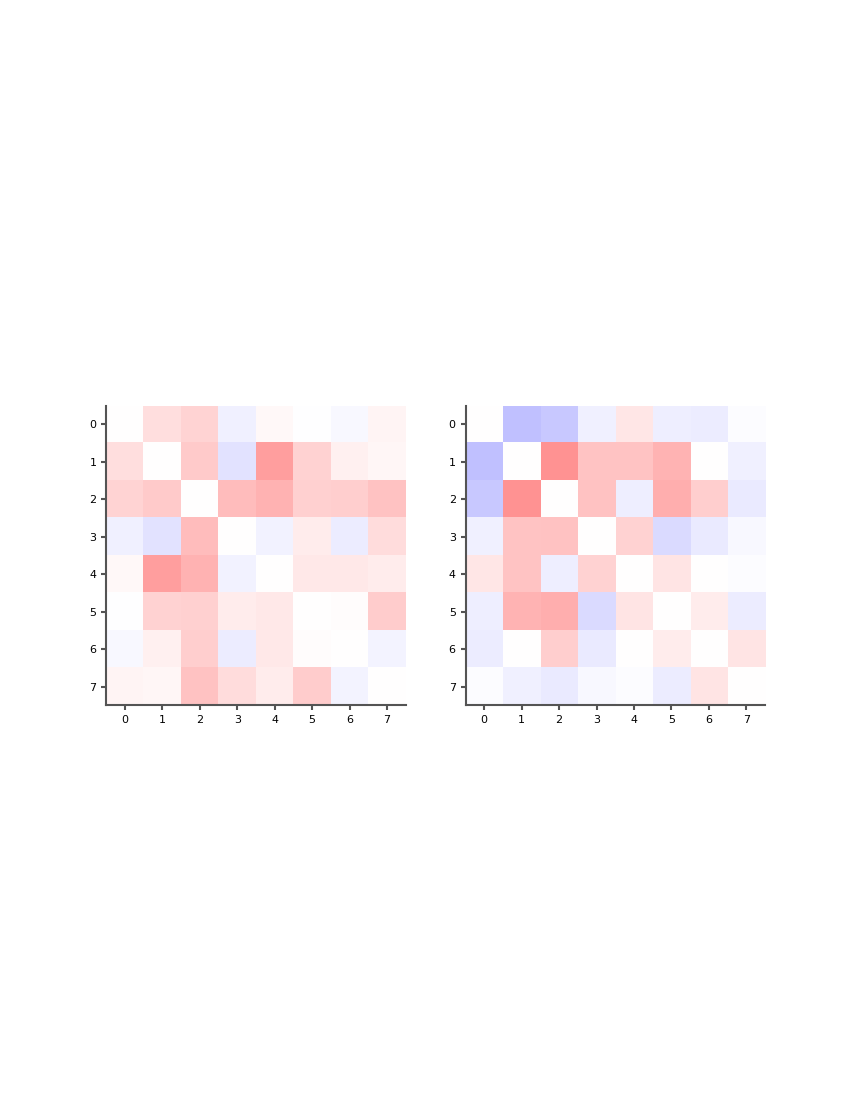

In [ ]:
%matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

fig = Fig(grid=(1,2))

for i,corrs in enumerate([corr_nsd,corr_sd]): 
    ax = fig.subplot(fig.gs[i])
    ax.imshow(np.nanmean(np.dstack(corrs),axis=-1),cmap='bwr',vmin=-0.2,vmax=0.2)